In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=3de0473925bd3bab0b272605f2865dc77472570ca7ec743533020349e98cfd21
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tripadvisor_hotel_reviews.csv')

In [ ]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
data.isnull().any()

,0
Review,False
Rating,False


In [ ]:
print(data['Rating'].describe())

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


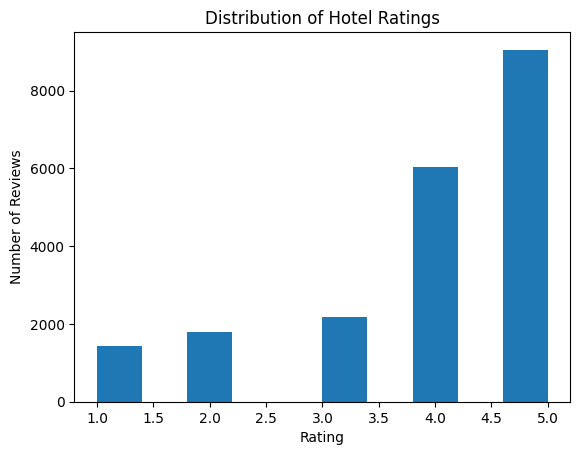

In [ ]:
rating_counts = data['Rating'].value_counts().sort_index()

plt.hist(data['Rating'])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Hotel Ratings')
plt.show()

In [ ]:
# Define a function to map rating to sentiment
def map_to_sentiment(rating):
  if rating > 3:
    return 2  # Positive
  elif rating == 3:
    return 1  # Neutral
  else:
    return 0  # Negative

# Create a new 'sentiment' column based on the rating
data['sentiment'] = data['Rating'].apply(map_to_sentiment)

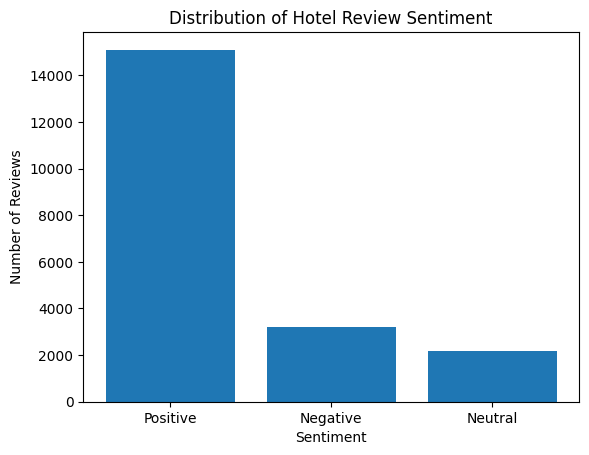

In [ ]:
# Get sentiment counts
sentiment_counts = data['sentiment'].value_counts()

# Map sentiment labels for visualization
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
sentiment_counts = sentiment_counts.rename(sentiment_labels)

# Create a histogram to visualize sentiment distribution
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Hotel Review Sentiment')
plt.show()

In [ ]:
data.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


In [ ]:
import re
def clean_text(text):
  """
  Cleans text by performing the following:
  - Lowercasing
  - Removing punctuation and special characters
  - Removing stop words (optional)
  """
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
  # You can optionally remove stop words using libraries like NLTK
  return text

In [ ]:
data['Review'] = data['Review'].apply(clean_text)
data.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4 experience hotel monaco seatt...,3,1
3,unique great stay wonderful time hotel monaco ...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [ ]:
max_features = 10000  # Maximum number of words in the vocabulary
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data['Review'])

In [ ]:
X = tokenizer.texts_to_sequences(data['Review'])
maxlen = 100  # Maximum length of a sequence
X = pad_sequences(X, padding='post', maxlen=maxlen)
y = data['sentiment']

In [ ]:
# Split data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Further split the training set into training and validation sets (80%/20%) with stratification
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y = y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(3, activation='softmax'))  # 3 output classes for sentiment

Class Weights: {0: 2.1249392318911036, 1: 3.1288475304223335, 2: 0.45253131794181595}


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/5
103/103 [==============================] - 18s 147ms/step - loss: 0.7669 - accuracy: 0.7310 - val_loss: 0.7190 - val_accuracy: 0.7383
Epoch 2/5
103/103 [==============================] - 8s 78ms/step - loss: 0.5414 - accuracy: 0.8058 - val_loss: 0.4783 - val_accuracy: 0.8253
Epoch 3/5
103/103 [==============================] - 7s 66ms/step - loss: 0.3753 - accuracy: 0.8633 - val_loss: 0.4315 - val_accuracy: 0.8347
Epoch 4/5
103/103 [==============================] - 4s 40ms/step - loss: 0.2889 - accuracy: 0.8927 - val_loss: 0.5104 - val_accuracy: 0.8234
Epoch 5/5
103/103 [==============================] - 4s 33ms/step - loss: 0.2315 - accuracy: 0.9191 - val_loss: 0.5590 - val_accuracy: 0.8106


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

129/129 [==============================] - 1s 6ms/step - loss: 0.5491 - accuracy: 0.8185
Accuracy: 0.8184922933578491


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

129/129 [==============================] - 1s 4ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_test and y_pred_classes are already defined
class_report = classification_report(y_test, y_pred_classes, digits=4)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0     0.6496    0.8103    0.7211       643
           1     0.3289    0.2265    0.2683       437
           2     0.9129    0.9059    0.9094      3019

    accuracy                         0.8185      4099
   macro avg     0.6305    0.6476    0.6329      4099
weighted avg     0.8093    0.8185    0.8115      4099


Confusion Matrix:
[[ 521   55   67]
 [ 144   99  194]
 [ 137  147 2735]]
